In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import gridspec
import copy
import os
from tqdm import tqdm 

from EightBitTransit.cTransitingImage import TransitingImage
from EightBitTransit.inversion import *
from EightBitTransit.misc import *
from scipy.optimize import lsq_linear

%matplotlib inline


import matplotlib.path as mpath
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Polygon
from matplotlib.patches import Rectangle
from matplotlib.patches import Wedge


from PIL import Image 


# Add spocc directory to the path to import spocc modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import data
import loaders


# These "magic" functions work in jupyter notebooks, this one reloads
# modules so if you make changes, you don't have to restart the notebook.
%load_ext autoreload
%autoreload 2

In [2]:
mag_bin = 14
tic =  357686299 #422305731

Flux at mid transit  0.01  0.04  0.09  0.16  0.24  0.34  0.45  0.58  0.70  \
Width                                                                       
1.0                   0.6   0.6   0.4   0.0   0.0   0.0   0.0   0.0   0.0   
2.0                   0.6   0.6   0.6   0.6   0.6   0.6   0.6   0.2   0.0   
3.0                   0.7   0.7   0.7   0.7   0.6   0.6   0.6   0.6   0.2   
4.0                   0.8   0.8   0.8   0.8   0.8   0.7   0.7   0.6   0.3   
5.0                   0.8   0.8   0.8   0.8   0.8   0.8   0.8   0.7   0.5   
6.0                   0.9   0.9   0.9   0.8   0.8   0.8   0.8   0.7   0.5   

Flux at mid transit  0.82  0.96  0.98  
Width                                  
1.0                   0.0   0.0   0.0  
2.0                   0.0   0.0   0.0  
3.0                   0.0   0.0   0.0  
4.0                   0.0   0.0   0.0  
5.0                   0.0   0.0   0.0  
6.0                   0.0   0.0   0.0  


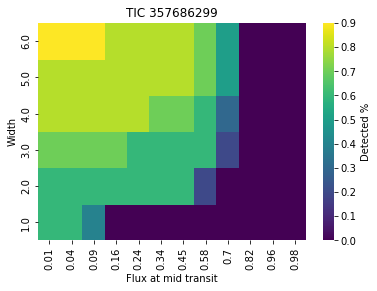

In [3]:
data = pd.read_csv(f'./heatmap_data_mag_{mag_bin}/{tic}_heatmap.csv')
data_pivoted = data.pivot("Width", "Flux at mid transit", "Detected")
print(data_pivoted)

data_pivoted = sns.heatmap(data_pivoted, cmap="viridis")


plt.title(f"TIC {tic}")
data_pivoted.collections[0].colorbar.set_label("Detected %")
data_pivoted.invert_yaxis()
plt.show()


In [4]:
# Mount data either from disk or bucket

data_dir = "/home/jupyter/mountpoint/"  # path for bucket

ref = loaders.load_ref(18, data_dir) #sector 18 camera 2

#subref = ref[ref.TIC_ID.isin([251630511])]#377199128 # overplot with this anomalous
subref = ref.loc[ref['Magnitude']>14]
print(subref)
tic_id = data_dir+subref.Filename.values[0]
tic_id = tic_id.split('_')[-1].split('.')[0]
print(tic_id)

                                                  Filename          RA  \
35       tesslcs_sector_18_104/2_min_cadence_targets/te...  275.124111   
50       tesslcs_sector_18_104/2_min_cadence_targets/te...   16.249241   
83       tesslcs_sector_18_104/2_min_cadence_targets/te...  283.291254   
141      tesslcs_sector_18_104/2_min_cadence_targets/te...  237.779619   
232      tesslcs_sector_18_104/2_min_cadence_targets/te...  357.036408   
...                                                    ...         ...   
2841738  tesslcs_sector_18_104/tesslcs_tmag_14_15/tessl...  250.551325   
2841739  tesslcs_sector_18_104/tesslcs_tmag_14_15/tessl...  250.665413   
2841740  tesslcs_sector_18_104/tesslcs_tmag_14_15/tessl...  250.632074   
2841741  tesslcs_sector_18_104/tesslcs_tmag_14_15/tessl...  239.338353   
2841742  tesslcs_sector_18_104/tesslcs_tmag_14_15/tessl...  263.168704   

               Dec      TIC_ID  Sector  Camera  CCD  Magnitude  
35       58.078045   357686299      18       4

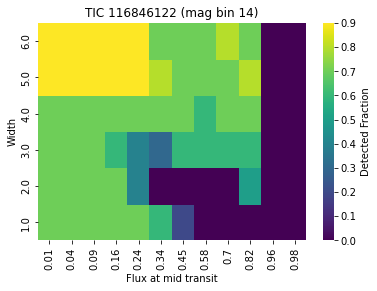

116846122


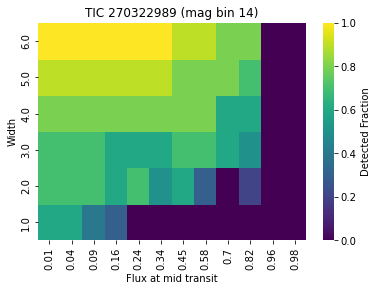

270322989


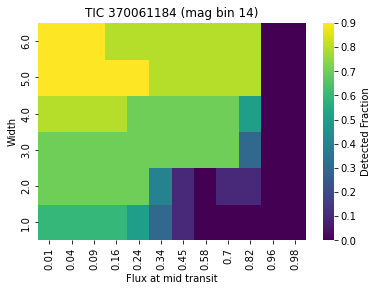

370061184


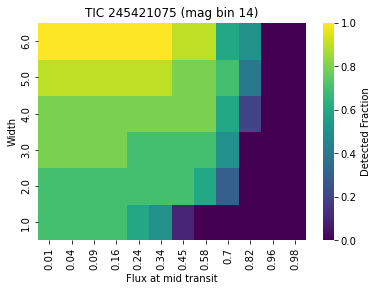

245421075


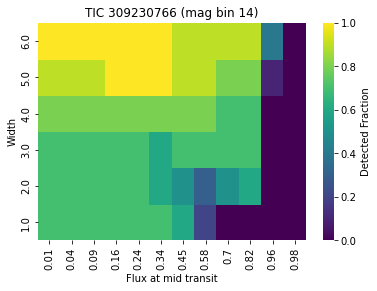

309230766


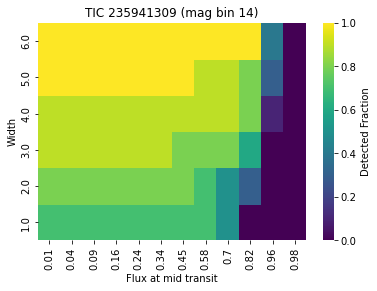

235941309


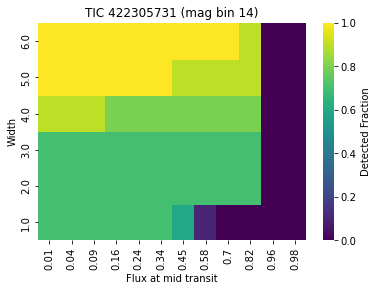

422305731


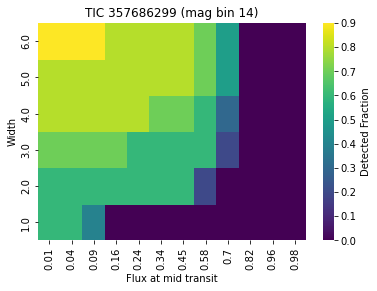

357686299


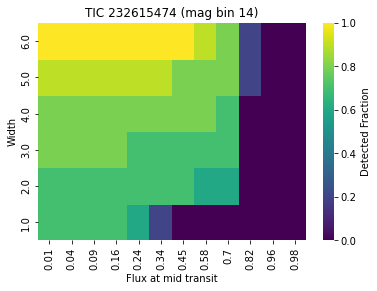

232615474


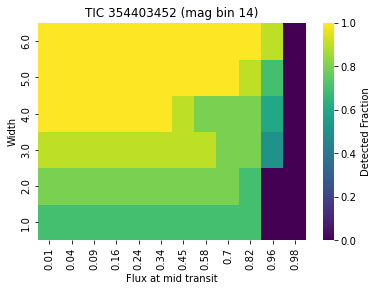

354403452
Flux at mid transit  0.01  0.04  0.09  0.16  0.24  0.34  0.45  0.58  0.70  \
Width                                                                       
1.0                  0.67  0.67  0.63  0.58  0.52  0.44  0.30  0.17  0.12   
2.0                  0.71  0.71  0.71  0.70  0.68  0.58  0.55  0.42  0.35   
3.0                  0.76  0.76  0.76  0.74  0.69  0.67  0.71  0.71  0.63   
4.0                  0.83  0.83  0.83  0.82  0.81  0.80  0.79  0.76  0.68   
5.0                  0.92  0.92  0.92  0.93  0.93  0.91  0.85  0.83  0.79   
6.0                  0.97  0.97  0.97  0.95  0.95  0.93  0.90  0.88  0.82   

Flux at mid transit  0.82  0.96  0.98  
Width                                  
1.0                  0.07  0.00   0.0  
2.0                  0.31  0.00   0.0  
3.0                  0.42  0.05   0.0  
4.0                  0.51  0.07   0.0  
5.0                  0.63  0.11   0.0  
6.0                  0.68  0.17   0.0  


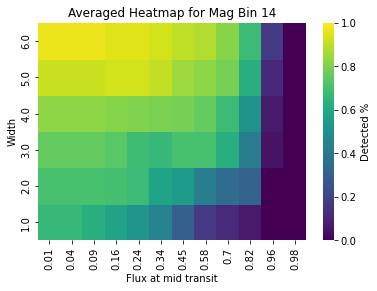

In [11]:
def average_heatmaps(folder_path, mag_bin):
    heatmap_files = [file for file in os.listdir(folder_path) if file.endswith(f'_heatmap.csv')]
    if len(heatmap_files) == 0:
        print("No heatmap files found in the specified folder.")
        return

    # Initialize an empty DataFrame to store the sum of heatmaps
    sum_heatmap = None

    for file in heatmap_files:
        file_path = os.path.join(folder_path, file)
        data = pd.read_csv(file_path)
        data_pivoted = data.pivot("Width", "Flux at mid transit", "Detected")
        single_data_pivoted = sns.heatmap(data_pivoted, cmap="viridis")#, vmin=0, vmax=1)

        plt.title(f"TIC {file[:-12]} (mag bin {mag_bin})")
        single_data_pivoted.collections[0].colorbar.set_label("Detected Fraction")
        single_data_pivoted.invert_yaxis()
        plt.show()
        
        # If it's the first file, set the sum_heatmap to the current heatmap
        if sum_heatmap is None:
            sum_heatmap = data_pivoted
        else:
            # Add the current heatmap to the sum_heatmap
            sum_heatmap += data_pivoted
            
        tic_id = int(file[:-12])
        print(tic_id)
        subref = ref[ref.TIC_ID==tic_id] 
        f0 = data_dir+subref.Filename.values[0]
        lc = loaders.load_lc(f0)
        lc = lc[lc.quality==0]
        lc = lc.normalize()
        time = lc.time.value
        time = [value - time[0] for value in time] #make time start at 0
        #plt.plot(time, lc.flux.value)
        #plt.title(tic_id)
        #plt.show()

    # Calculate the average heatmap by dividing the sum_heatmap by the number of files
    #print(sum_heatmap)
    average_heatmap = sum_heatmap / len(heatmap_files)
    print(average_heatmap)
    # Plot the averaged heatmap
    ax = sns.heatmap(average_heatmap, cmap="viridis", vmin=0, vmax=1)
    plt.title(f"Averaged Heatmap for Mag Bin {mag_bin}")
    plt.xlabel("Flux at mid transit")
    plt.ylabel("Width")
    ax.invert_yaxis()

    cbar = ax.collections[0].colorbar
    cbar.set_label("Detected %")

    plt.show()


# Example usage
mag_bin = 14# Write in desired mag bin

folder_path = f'./heatmap_data_mag_{mag_bin}/'
average_heatmaps(folder_path, mag_bin)

#plot lcs